In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
from sklearn.model_selection import train_test_split
import concurrent.futures
import pickle

minMovies = 20
# Load data
print("Loading data...")
data = pd.read_csv('movielens-20m/rating.csv')
data = data.iloc[:1000000]
print(f"Total records: {len(data)}")

# Filter movies with less than 50 ratings
print("Filtering movies with less than 50 ratings...")
movie_counts = data['movieId'].value_counts()
filtered_movie_ids = movie_counts[movie_counts >= minMovies].index
data = data[data['movieId'].isin(filtered_movie_ids)]
print(f"Records after filtering: {len(data)}")

# Split data
print("Splitting data into train and test sets...")
unique_user_ids = data['userId'].unique()
train_user_ids, test_user_ids = train_test_split(unique_user_ids, test_size=0.2, random_state=42)
train_data = data[data['userId'].isin(train_user_ids)]
test_data = data[data['userId'].isin(test_user_ids)]
print(f"Training data size: {len(train_data)}, Test data size: {len(test_data)}")

Loading data...
Total records: 1000000
Filtering movies with less than 50 ratings...
Records after filtering: 953804
Splitting data into train and test sets...
Training data size: 765825, Test data size: 187979


Building the graph

In [7]:
# Initialize the graph
print("Building the graph...")
G = nx.Graph()
movie_ids = train_data['movieId'].unique()
G.add_nodes_from(movie_ids)

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define a function to update the edge weight based on user opinion
def update_edge_weight(G, movie1, movie2, rating1, rating2, threshold=3.5, max_rating=5.0):
    if G.has_edge(movie1, movie2):
        raw_score = G[movie1][movie2]['raw_score']
    else:
        raw_score = 0  # Initialize with a neutral score

    # Calculate score change
    if rating1 > threshold and rating2 > threshold:
        score_change = (rating1 + rating2) / (2 * max_rating)
    elif rating1 <= threshold and rating2 > threshold:
        score_change = (rating1 - rating2) / (2 * max_rating)
    elif rating1 > threshold and rating2 <= threshold:
        score_change = (rating2 - rating1) / (2 * max_rating)
    else:
        score_change = 0  # Do nothing if both are rated negatively

    # Update the raw score
    raw_score += score_change

    # Update the graph with raw score and weight
    G.add_edge(movie1, movie2, raw_score=raw_score, weight=sigmoid(raw_score))

# Iterate over users and update the graph based on their opinions
for user_id, group in train_data.groupby('userId'):
    movies_rated_by_user = group['movieId'].tolist()
    ratings_given_by_user = group['rating'].tolist()
    for i in range(len(movies_rated_by_user)):
        for j in range(i+1, len(movies_rated_by_user)):
            update_edge_weight(G, movies_rated_by_user[i], movies_rated_by_user[j], 
                               ratings_given_by_user[i], ratings_given_by_user[j])

# Save the graph
print("Saving the graph...")
with open(f'graph{len(train_data)}-user_opinion_sigmoid-notebook.pkl', 'wb') as f:
    pickle.dump(G, f)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")



Building the graph...
Saving the graph...
Graph created with 5064 nodes and 11373660 edges.


Functions

In [4]:
def recommend_movies(graph, user_ratings, seen_movies, top_n=10, max_from_single_movie=3):
    movie_scores = {}
    for movie, rating in user_ratings.items():
        if movie not in graph:
            continue
        neighbors = [(nbr, data['weight']) for nbr, data in graph[movie].items() if nbr not in seen_movies]
        neighbors.sort(key=lambda x: x[1], reverse=True)
        for idx, (nbr, weight) in enumerate(neighbors):
            if idx >= max_from_single_movie:
                break
            score = rating * weight
            if nbr in movie_scores:
                movie_scores[nbr] += score
            else:
                movie_scores[nbr] = score
    recommended_movies = sorted(movie_scores.keys(), key=lambda x: movie_scores[x], reverse=True)
    return recommended_movies[:top_n]

# Predict rating function
def predict_rating(graph, user_ratings, hidden_movie):
    total_weight = 0
    weighted_sum = 0

    for movie, rating in user_ratings.items():
        if movie not in graph:
            continue

        # Check if the seen movie is a neighbor of the hidden movie
        if graph.has_edge(movie, hidden_movie):
            weight = graph[movie][hidden_movie]['weight']
            total_weight += abs(weight)  # Use absolute value to normalize
            weighted_sum += weight * 5

    # Return the weighted average if there are any neighbors, otherwise return a default (e.g., mean rating)
    return weighted_sum / total_weight if total_weight > 0 else np.mean(list(user_ratings.values()))

# Evaluation function
def evaluate_for_user(user_data):
    user_id, group = user_data
    user_ratings = dict(zip(group['movieId'], group['rating']))
    scores = []
    
    for hidden_movie, hidden_rating in user_ratings.items():
        # Hide the current movie
        remaining_ratings = {movie: rating for movie, rating in user_ratings.items() if movie != hidden_movie}
        
        # Predict the rating for the hidden movie based on the remaining movies
        predicted_rating = predict_rating(G, remaining_ratings, hidden_movie)
        
        # Append the predicted rating and the actual rating to the scores list
        scores.append((predicted_rating, hidden_rating))
    
    return scores

Evaluating the Graph

In [9]:
print("Evaluating the recommender system...")
all_scores = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    for scores_for_user in executor.map(evaluate_for_user, test_data.groupby('userId')):
        all_scores.extend(scores_for_user)

predicted_ratings, actual_ratings = zip(*all_scores)
mae = np.mean(np.abs(np.array(predicted_ratings) - np.array(actual_ratings)))
print(f"Mean Absolute Error between predicted and actual ratings: {mae:.4f}")

# Save the results periodically
print("Saving the results...")
with open(f'results{len(test_data)}-notebook.pkl', 'wb') as f:
    pickle.dump((predicted_ratings, actual_ratings), f)

Evaluating the recommender system...


Mean Absolute Error between predicted and actual ratings: 1.4540
Saving the results...


/tmp/ipykernel_4408/3913646752.py:22: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subG, pos, edgelist=[(u, v)], width=d['weight'])


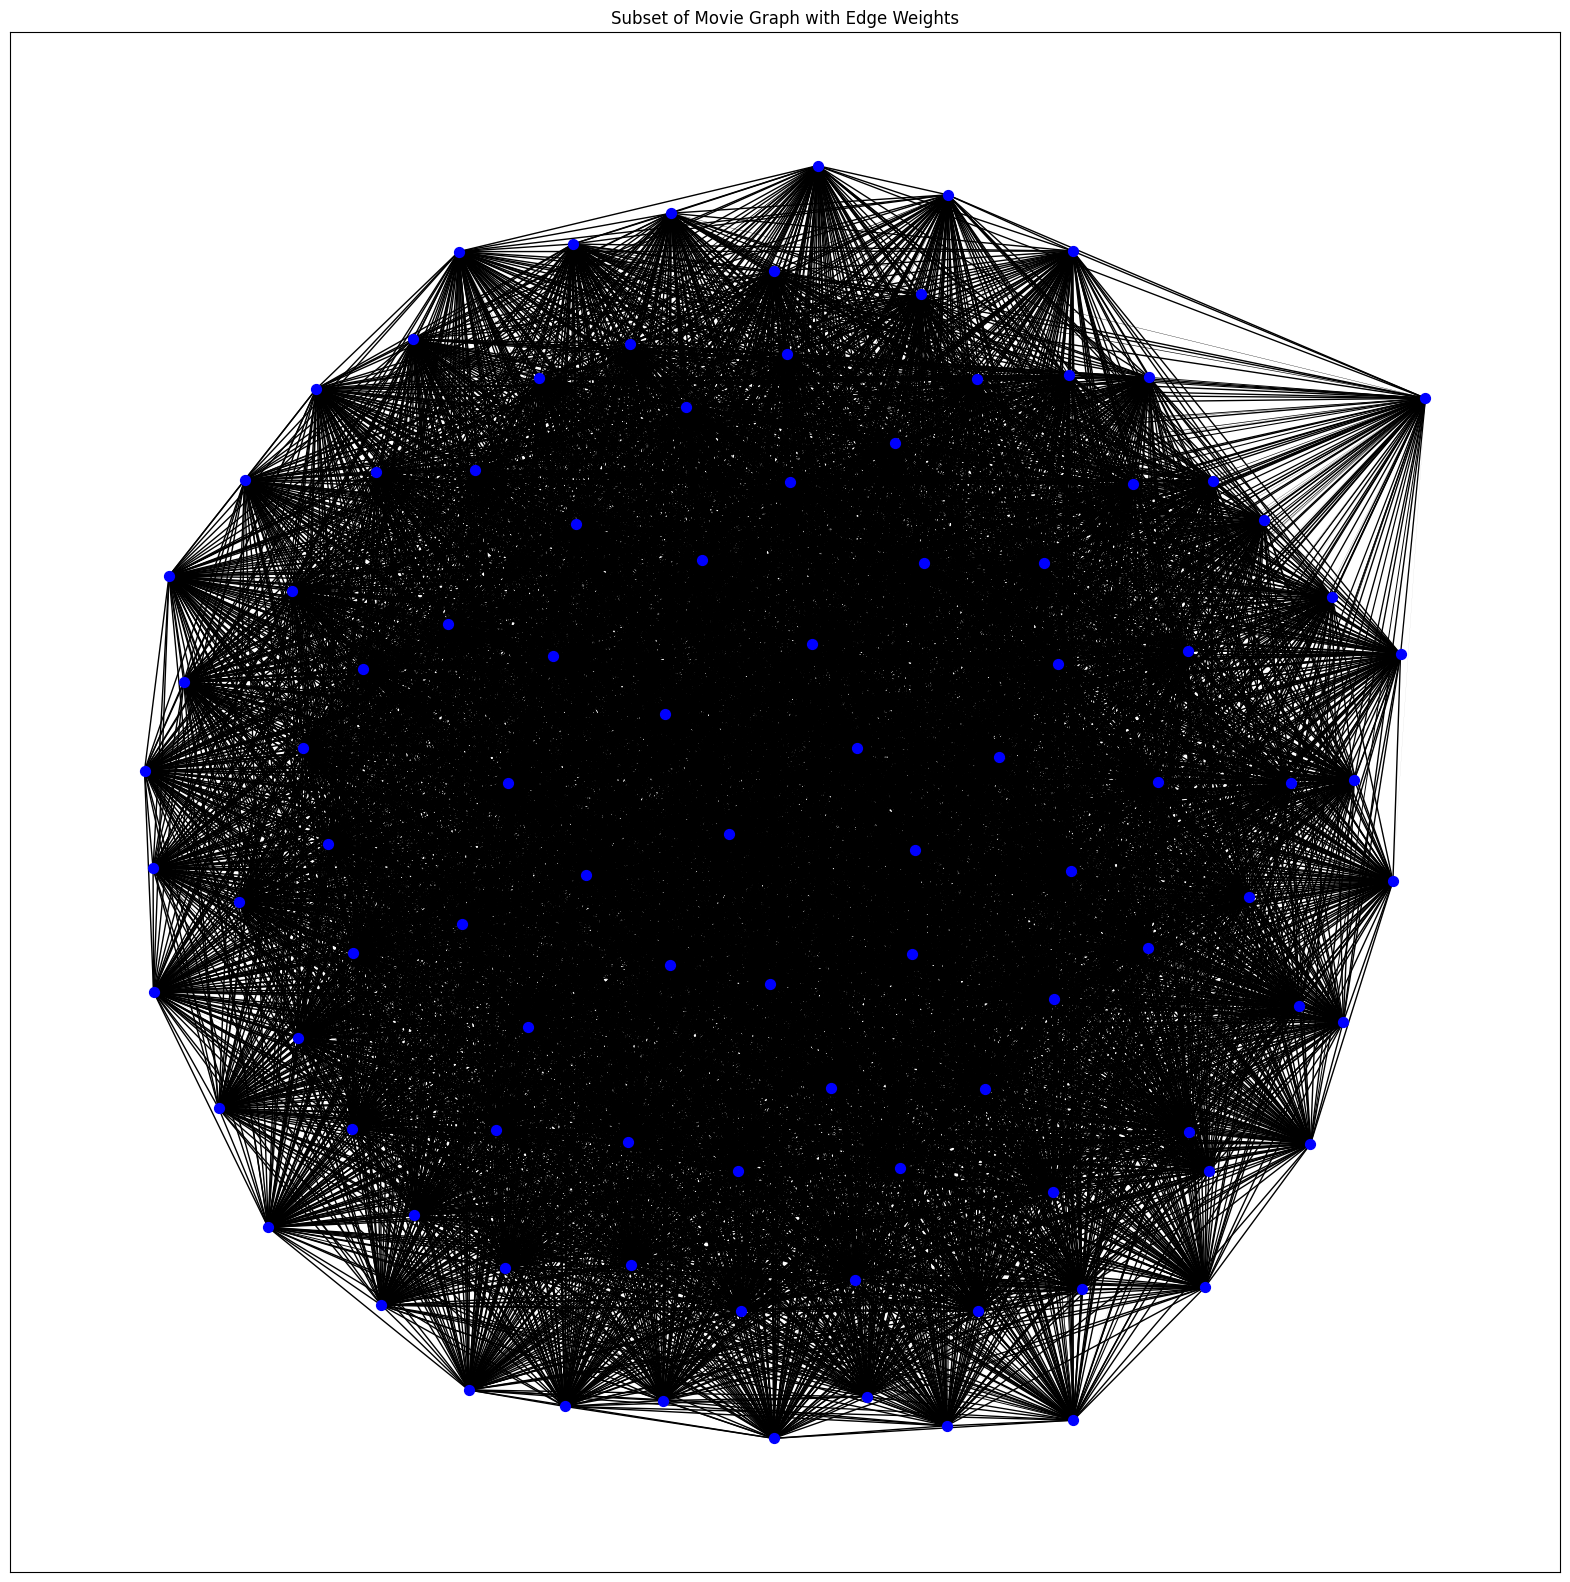

Number of nodes: 3215
Number of edges: 4754564
Average degree: 2957.738102643857
The graph is connected.


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming your graph is stored in the variable G

# Get the top 100 nodes with the highest degree
top_nodes = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:100]
top_node_ids = [node[0] for node in top_nodes]

# Create a subgraph with these nodes
subG = G.subgraph(top_node_ids)

# Define positions for the nodes
pos = nx.spring_layout(subG)

# Draw nodes
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(subG, pos, node_size=50, node_color='blue')

# Draw edges with thickness based on weight
for (u, v, d) in subG.edges(data=True):
    nx.draw_networkx_edges(subG, pos, edgelist=[(u, v)], width=d['weight'])

plt.title("Subset of Movie Graph with Edge Weights")
plt.show()

# Print properties of the graph
print(f"Number of nodes: {len(G.nodes())}")
print(f"Number of edges: {len(G.edges())}")
print(f"Average degree: {sum(dict(G.degree()).values()) / len(G)}")

# Check connectedness
if nx.is_connected(G):
    print("The graph is connected.")
else:
    print("The graph is not connected.")
    print(f"There are {nx.number_connected_components(G)} connected components.")